<a href="https://colab.research.google.com/github/DTribek/PythonProjects/blob/master/FIA_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset Description**


Bank client data:

1.   Age (numeric)
2.   Job : type of job  (categorical)
1.   Marital : marital status (categorical)
2.   Education (categorical)
1.   Default: has credit in default? (categorical)
2.   Housing: has housing loan? (categorical)
1.   Loan: has personal loan? (categorical)
1.   Contact: contact communication type (categorical)
2.   Month: Month of year (categorical’)
1.   Day_of_week: Day of the week (categorical)
2.   Duration: In seconds (numeric)
1.   Campaign: number of contacts performed during the campaign (numeric) 
2.   Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) 
1.   Previous: number of contacts performed before this campaign and for this client (numeric) 
2.   Poutcome: outcome of the previous marketing campaign (categorical)
1.   Emp.var.rate: employment variation rate (numeric)
2.   Cons.price.idx: consumer price index - monthly indicator (numeric)
1.   Cons.conf.idx: consumer confidence index - monthly indicator (numeric)
2.   Euribor3m: euribor 3 month rate - daily indicator (numeric)
1.   Nr.employed: number of employees - quarterly indicator (numeric)
2.  Output variable (desired target) has the client subscribed a term deposit? (binary: ‘yes’, ‘no’)

#**What is a Term Deposit?**

A Term deposit is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time. For more information with regards to Term Deposits please click on this link from Investopedia: https://www.investopedia.com/terms/t/termdeposit.asp



# **Import DataSet from Git**

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns',500)

url = 'https://raw.githubusercontent.com/DTribek/datasets/master/bank-additional-full.csv'

df = pd.read_csv(url,sep=';')

# Data Exploration
##Check for missing values and target balance

In [0]:
print('Missing values Count')
print(df.isnull().sum())

Missing values Count
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


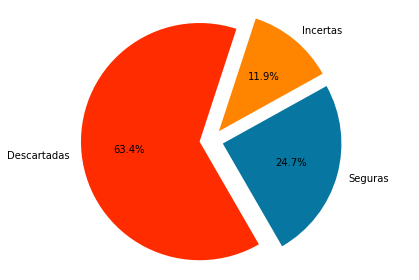

In [0]:
# Pie chart
labels = ['Seguras', 'Incertas', 'Descartadas']
sizes = [1687,813,4323]
colors = ['#0776a0','#Ff8500','#FF2C00']             

# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.1, 0.1, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=colors, startangle=300)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Target variable is not balanced. This might be a problem, since if we predict everyone to be false, we will have an accuracy near 90%

We will drop duration from our database, since we only know the duration after contacted the client. Also, we will remap our target variable.

In [0]:
df['target'] = df['y'].map({'yes': 1, 'no': 0}) 
df.drop(columns='y',inplace = True)
df.drop(columns='duration',inplace = True)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'target'],
      dtype='object')

Histogram will be displayed for all numeric variables

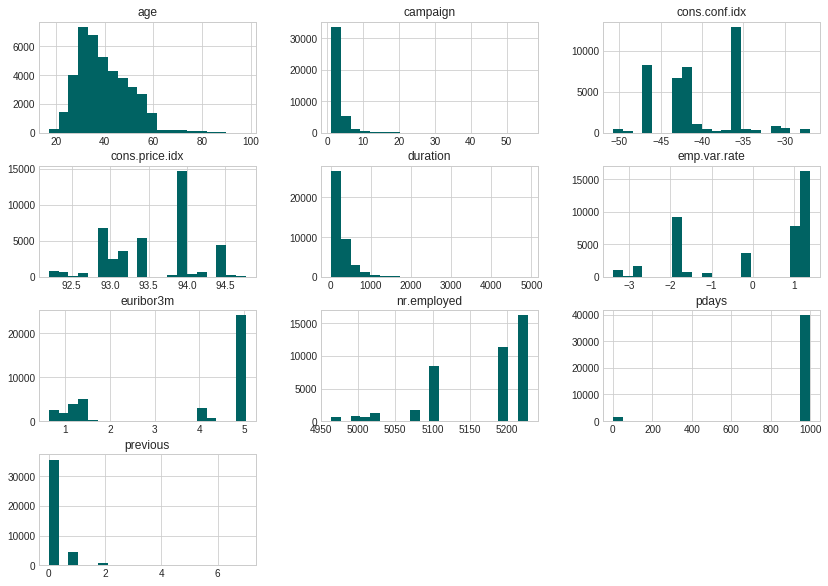

In [0]:

plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10), color='#006363')
plt.show()

#Numerical Analysis
    Our numeric data is not following a normal distribution. Let's try to work on it and see if we can split it in groups to make the correlation with the target variable better

#AGE

Let's split the data between 1 and 0 for target.

In [0]:
df0 = df[df['target']==0]
df1 = df[df['target']==1]

Show histograms for both groups

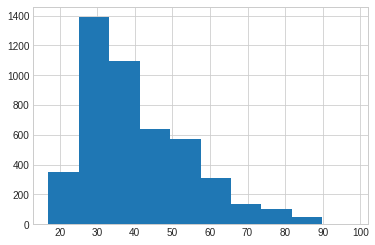

In [0]:
df1['age'].hist()

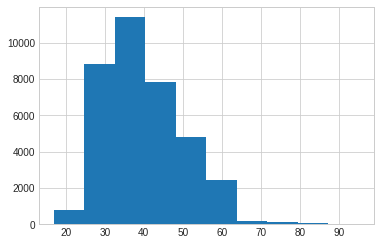

In [0]:
df0['age'].hist()

Let's try to split age in different groups to see if any of them seens reasonable to work with. Apprently elderly people are more likely to do a term deposit.

In [0]:
def split_age(dataframe):
  df = dataframe.copy()
  df['age_under_35'] = np.where( df['age']<=35, 1, 0)
  df['age_above_30'] = np.where( df['age']<=30, 1, 0)
  df['age_under_25'] = np.where( df['age']<=25, 1, 0)
  df['age_above_20'] = np.where( df['age']<=20, 1, 0)
  df['age_above_55'] = np.where( df['age']>=55, 1, 0)
  df['age_above_60'] = np.where( df['age']>=60, 1, 0)
  df['age_above_65'] = np.where( df['age']>=65, 1, 0)
  df['age_25-35']    = np.where((df['age']>25) & (df['age']< 35)  , 1, 0)
  df['age_35-45']    = np.where((df['age']>35) & (df['age']< 45)  , 1, 0)
  df['age_45-60']    = np.where((df['age']>45) & (df['age']< 60)  , 1, 0)
  df['age_25-45']    = np.where((df['age']>25) & (df['age']< 45)  , 1, 0)
  df['age_25-55']    = np.where((df['age']>25) & (df['age']< 55)  , 1, 0)
  df['age_45-55']    = np.where((df['age']>=45) & (df['age']<= 55)  , 1, 0)
  df['age_25-60']    = np.where((df['age']>25) & (df['age']< 60)  , 1, 0)
  df['age_55-60']    = np.where((df['age']>=55) & (df['age']< 60)  , 1, 0)
  
  print(df.corr()['target'])

In [0]:
split_age(df)

age               0.030399
campaign         -0.066357
pdays            -0.324914
previous          0.230181
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
target            1.000000
age_under_35      0.035841
age_above_30      0.058515
age_under_25      0.062879
age_above_20      0.054396
age_above_55      0.081067
age_above_60      0.154584
age_above_65      0.145413
age_25-35         0.016259
age_35-45        -0.054717
age_45-60        -0.037267
age_25-45        -0.040815
age_25-55        -0.105638
age_45-55        -0.044825
age_25-60        -0.150745
age_55-60        -0.005034
Name: target, dtype: float64


As we can see from the histogram, our target variable, term deposit, has a different behavior depending on ages. Running the function to find the correlation we can see that ideally age should be split in three groups. 

1.   **Group 1:** People under 25 y.o. **(Young)**
1.   **Group 2:** People from 25-60 y.o. **(Mid Age)**
2.   **Group 3:** People above 60y.o. **(Elderly)**



In [0]:
df['age_young']   = np.where( df['age']<=25, 1, 0)
df['age_mid_age'] = np.where((df['age']>25) & (df['age']< 60)  , 1, 0)
df['age_elder']     = np.where( df['age']>60, 1, 0)

#CAMPAIGN

Same strategy as age...

In [0]:
df0 = df[df['target']==0]
df1 = df[df['target']==1]

Let's see the distribution for each group

In [0]:
print("DF_0:{}".format(dict(df0['campaign'].value_counts()/len(df0))))
print("DF_1:{}".format(dict(df1['campaign'].value_counts())))

DF_0:{1: 0.41977673196891757, 2: 0.2560742037868009, 3: 0.13043121374630623, 4: 0.0657217905220532, 5: 0.0404673306336872, 6: 0.024734595600306445, 7: 0.016170515486483527, 8: 0.010479369596147531, 9: 0.007278100032833534, 10: 0.005827952281930612, 11: 0.004514610922622305, 12: 0.0033380759549086134, 13: 0.0024077924920652295, 14: 0.001860566925686768, 17: 0.0014775090292218453, 16: 0.001395425194265076, 15: 0.00134070263762723, 18: 0.0009029221845244609, 20: 0.0008208383495676918, 19: 0.0007113932362919996, 21: 0.0006566706796541534, 22: 0.000465141731421692, 24: 0.0004104191747838459, 23: 0.0004104191747838459, 27: 0.0003009740615081537, 29: 0.0002736127831892306, 25: 0.0002188902265513845, 26: 0.0002188902265513845, 28: 0.0002188902265513845, 30: 0.0001915289482324614, 31: 0.0001915289482324614, 35: 0.0001368063915946153, 33: 0.00010944511327569225, 32: 0.00010944511327569225, 34: 8.208383495676918e-05, 40: 5.472255663784612e-05, 42: 5.472255663784612e-05, 43: 5.472255663784612e-05,

In [0]:
df['campaign_C1']   = np.where( df['campaign']==1, 1, 0)
df['campaign_C2']   = np.where( df['campaign']==2, 1, 0)
df['campaign_C3']   = np.where( df['campaign']==3, 1, 0)
df['campaign_C4']   = np.where( df['campaign']==4, 1, 0)
df['campaign_C5']   = np.where( df['campaign']==5, 1, 0)
df['campaign_C6']   = np.where( df['campaign']>=6, 1, 0)

In [0]:
df.corr()['target']

age               0.030399
campaign         -0.066357
pdays            -0.324914
previous          0.230181
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
target            1.000000
age_young         0.062879
age_mid_age      -0.150745
age_elder         0.162728
campaign_C1       0.048504
campaign_C2       0.003559
campaign_C3      -0.006329
campaign_C4      -0.015535
campaign_C5      -0.023905
campaign_C6      -0.054616
Name: target, dtype: float64

Correlation did not improve, let's drop the new columns and stay with the campaign

In [0]:
df.drop(columns=['campaign_C1','campaign_C2','campaign_C3','campaign_C4','campaign_C5','campaign_C6'],inplace=True)

#PDays

We will see how pdays is distributed across the groups

In [0]:
print("DF:{}".format(dict(df['pdays'].value_counts()/len(df))))
print("DF_0:{}".format(dict(df0['pdays'].value_counts()/len(df0))))
print("DF_1:{}".format(dict(df1['pdays'].value_counts()/len(df1))))

DF:{999: 0.9632174419733903, 3: 0.010658444207050597, 6: 0.010002913469942702, 4: 0.0028649121103233952, 9: 0.0015538506361076042, 2: 0.0014810138875400603, 7: 0.001456734971350879, 12: 0.0014081771389725163, 10: 0.0012625036418374284, 5: 0.0011168301447023405, 13: 0.0008740409828105274, 11: 0.0006798096532970768, 1: 0.0006312518209187142, 15: 0.0005826939885403516, 14: 0.0004855783237836263, 8: 0.0004370204914052637, 0: 0.00036418374283771974, 16: 0.00026706807808099444, 17: 0.00019423132951345052, 18: 0.0001699524133242692, 19: 7.283674856754395e-05, 22: 7.283674856754395e-05, 21: 4.855783237836263e-05, 26: 2.4278916189181315e-05, 20: 2.4278916189181315e-05, 25: 2.4278916189181315e-05, 27: 2.4278916189181315e-05}
DF_0:{999: 0.9850060194812301, 3: 0.0038579402429681515, 6: 0.0033654372332275364, 4: 0.0015048703075407684, 12: 0.000875560906205538, 9: 0.0007934770712487687, 2: 0.0006566706796541534, 10: 0.0006019481230163074, 7: 0.0005472255663784612, 1: 0.000492503009740615, 5: 0.00046

In [0]:
df['pdays_999']   = np.where( df['pdays']==999, 1, 0)

In [0]:
df.corr()['target']

age               0.030399
campaign         -0.066357
pdays            -0.324914
previous          0.230181
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
target            1.000000
age_young         0.062879
age_mid_age      -0.150745
age_elder         0.162728
campaign_C1       0.048504
campaign_C2       0.003559
campaign_C3      -0.006329
campaign_C4      -0.015535
campaign_C5      -0.023905
campaign_C6      -0.054616
pdays_999        -0.324877
Name: target, dtype: float64

Pdays numeric will probably make the model a little worse. It's seems reasonable to map only if the client was previously contacted or not. Also, since we will do normalization, pdays will basically become a true or false column

#Previous

We will see how previous is distributed now...

In [0]:
df['previous'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

(array([3.5563e+04, 4.5610e+03, 7.5400e+02, 0.0000e+00, 2.1600e+02,
        7.0000e+01, 0.0000e+00, 1.8000e+01, 5.0000e+00, 1.0000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

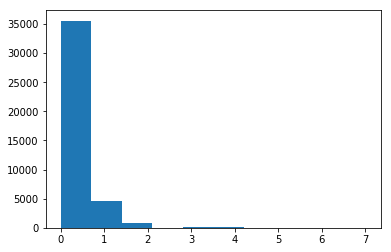

In [0]:
plt.hist(df['previous'])

Count the values for each value

In [0]:
print("DF:{}".format(dict(df['previous'].value_counts()/len(df))))
print("DF_0:{}".format(dict(df0['previous'].value_counts()/len(df0))))
print("DF_1:{}".format(dict(df1['previous'].value_counts()/len(df1))))

Create new groups

In [0]:
df['previous_P0']   = np.where( df['previous']==0, 1, 0)
df['previous_P1']   = np.where( df['previous']==1, 1, 0)
df['previous_P2']   = np.where( df['previous']>1, 1, 0)

In [0]:
df.corr()['target']

age               0.030399
campaign         -0.066357
pdays            -0.324914
previous          0.230181
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
target            1.000000
age_young         0.062879
age_mid_age      -0.150745
age_elder         0.162728
campaign_C1       0.048504
campaign_C2       0.003559
campaign_C3      -0.006329
campaign_C4      -0.015535
campaign_C5      -0.023905
campaign_C6      -0.054616
pdays_999        -0.324877
campaign_P0      -0.193507
campaign_P1       0.110898
campaign_P2       0.199502
campaign_log     -0.069780
previous_P0      -0.193507
previous_P1       0.110898
previous_P2       0.199502
Name: target, dtype: float64

Correlation did not improve for this case.

#Emp.Var.Rate

(array([ 1243.,  1663.,     0.,  9957.,   635.,     0.,  3693.,     0.,
            0., 23997.]),
 array([-3.4 , -2.92, -2.44, -1.96, -1.48, -1.  , -0.52, -0.04,  0.44,
         0.92,  1.4 ]),
 <a list of 10 Patch objects>)

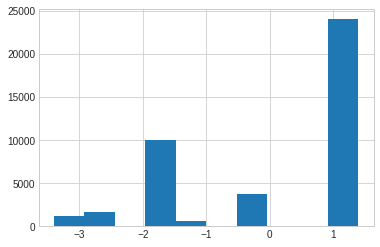

In [0]:
plt.hist(df['emp.var.rate'])

(array([ 542.,  594.,    0., 1864.,  301.,    0.,  233.,    0.,    0.,
        1106.]),
 array([-3.4 , -2.92, -2.44, -1.96, -1.48, -1.  , -0.52, -0.04,  0.44,
         0.92,  1.4 ]),
 <a list of 10 Patch objects>)

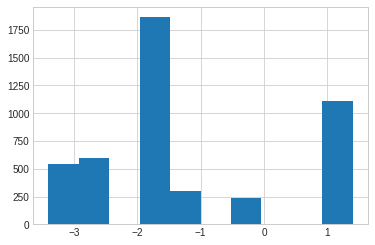

In [0]:
plt.hist(df1['emp.var.rate'])

(array([  701.,  1069.,     0.,  8093.,   334.,     0.,  3460.,     0.,
            0., 22891.]),
 array([-3.4 , -2.92, -2.44, -1.96, -1.48, -1.  , -0.52, -0.04,  0.44,
         0.92,  1.4 ]),
 <a list of 10 Patch objects>)

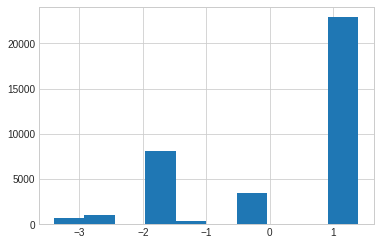

In [0]:
plt.hist(df0['emp.var.rate'])

In [0]:
print("DF:{}".format(dict(df['emp.var.rate'].value_counts()/len(df))))
print("DF_0:{}".format(dict(df0['emp.var.rate'].value_counts()/len(df0))))
print("DF_1:{}".format(dict(df1['emp.var.rate'].value_counts()/len(df1))))

DF:{1.4: 0.39414392541516946, -1.8: 0.2229775662814412, 1.1: 0.18847722637661454, -0.1: 0.08941924832475479, -2.9: 0.040375837622608525, -3.4: 0.02600271923861319, -1.7: 0.018767602214237157, -1.1: 0.015417111780130135, -3.0: 0.0041759735845391865, -0.2: 0.00024278916189181314}
DF_0:{1.4: 0.42048812520520956, -1.8: 0.2113111524570428, 1.1: 0.20583889679325817, -0.1: 0.09442377147860348, -2.9: 0.029249206522928752, -3.4: 0.016881908722775528, -1.7: 0.010123672978001532, -1.1: 0.009138666958520301, -3.0: 0.002298347378789537, -0.2: 0.0002462515048703075}
DF_1:{-1.8: 0.3148706896551724, 1.4: 0.18663793103448276, -2.9: 0.12801724137931034, -3.4: 0.0978448275862069, -1.7: 0.08685344827586207, -1.1: 0.06487068965517241, 1.1: 0.05172413793103448, -0.1: 0.05, -3.0: 0.01896551724137931, -0.2: 0.00021551724137931034}


In [0]:
df.corr()['target']

age               0.030399
campaign         -0.066357
pdays            -0.324914
previous          0.230181
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
target            1.000000
age_young         0.062879
age_mid_age      -0.150745
age_elder         0.162728
campaign_C1       0.048504
campaign_C2       0.003559
campaign_C3      -0.006329
campaign_C4      -0.015535
campaign_C5      -0.023905
campaign_C6      -0.054616
pdays_999        -0.324877
Name: target, dtype: float64

#cons.price.idx

In [0]:
print("DF:{}".format(dict(df['cons.price.idx'].value_counts()/len(df))))
print("DF_0:{}".format(dict(df0['cons.price.idx'].value_counts()/len(df0))))
print("DF_1:{}".format(dict(df1['cons.price.idx'].value_counts()/len(df1))))

DF:{93.994: 0.18847722637661454, 93.91799999999999: 0.16230455472467709, 92.89299999999999: 0.14067204040011655, 93.444: 0.1256433912790133, 94.465: 0.10619597941147907, 93.2: 0.08779256094007963, 93.075: 0.05967757599300767, 92.20100000000001: 0.018694765465669613, 92.963: 0.01735942507526464, 92.431: 0.010852675536564048, 92.649: 0.00866757307953773, 94.215: 0.007550742934835389, 94.199: 0.007356511605321938, 92.84299999999999: 0.006846654365349131, 92.37899999999999: 0.006482470622511411, 93.369: 0.0064096338739438674, 94.027: 0.005656987472079246, 94.055: 0.005559871807322521, 93.876: 0.005147130232106439, 94.601: 0.004952898902592988, 92.469: 0.004321647081674274, 93.749: 0.004224531416917549, 92.713: 0.0041759735845391865, 94.76700000000001: 0.0031077012722152083, 93.79799999999999: 0.001626687384675148, 92.756: 0.00024278916189181314}
DF_0:{93.994: 0.20583889679325817, 93.91799999999999: 0.17177410528619896, 92.89299999999999: 0.14419393674072453, 93.444: 0.1341797088759987, 94.

(array([  934.,   385.,  5886.,  5442.,  5018.,     0., 13993.,   523.,
         4186.,   181.]),
 array([92.201 , 92.4576, 92.7142, 92.9708, 93.2274, 93.484 , 93.7406,
        93.9972, 94.2538, 94.5104, 94.767 ]),
 <a list of 10 Patch objects>)

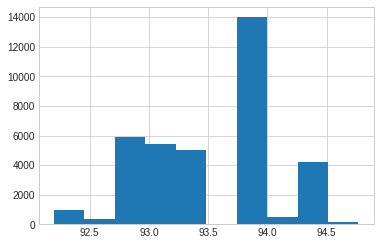

In [0]:
plt.hist(df0['cons.price.idx'])

(array([550., 322., 915., 632., 421.,   0., 908., 553., 188., 151.]),
 array([92.201 , 92.4576, 92.7142, 92.9708, 93.2274, 93.484 , 93.7406,
        93.9972, 94.2538, 94.5104, 94.767 ]),
 <a list of 10 Patch objects>)

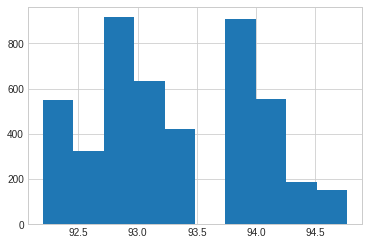

In [0]:
plt.hist(df1['cons.price.idx'],bins=10)

In [0]:
df['cons.price.idx'].unique()

In [0]:
def split_cons_price_idx(dataframe):
    df = dataframe.copy()
    df['cons_price_above'] = np.where( df['cons.price.idx']>93.5, 1, 0)
    df['cons_price_below'] = np.where( df['cons.price.idx']<=92.75, 1, 0)
    df['cons_price_mid']   = np.where( (df['cons.price.idx']>92.75) & (df['cons.price.idx']< 93.5), 1, 0)
    print(df.corr()['target'])

In [0]:
split_cons_price_idx(df)

age                 0.030399
campaign           -0.066357
pdays              -0.324914
previous            0.230181
emp.var.rate       -0.298334
cons.price.idx     -0.136211
cons.conf.idx       0.054878
euribor3m          -0.307771
nr.employed        -0.354678
target              1.000000
age_young           0.062879
age_mid_age        -0.150745
age_elder           0.162728
campaign_C1         0.048504
campaign_C2         0.003559
campaign_C3        -0.006329
campaign_C4        -0.015535
campaign_C5        -0.023905
campaign_C6        -0.054616
pdays_999          -0.324877
cons_price_above   -0.081403
cons_price_below    0.213917
cons_price_mid     -0.014703
Name: target, dtype: float64


In [0]:
df['cons_price_above'] = np.where( df['cons.price.idx']>93.5, 1, 0)
df['cons_price_below'] = np.where( df['cons.price.idx']<=92.75, 1, 0)
df['cons_price_mid']   = np.where( (df['cons.price.idx']>92.75) & (df['cons.price.idx']< 93.5), 1, 0)

In [0]:
df.corr()['target']

age                 0.030399
campaign           -0.066357
pdays              -0.324914
previous            0.230181
emp.var.rate       -0.298334
cons.price.idx     -0.136211
cons.conf.idx       0.054878
euribor3m          -0.307771
nr.employed        -0.354678
target              1.000000
age_young           0.062879
age_mid_age        -0.150745
age_elder           0.162728
campaign_C1         0.048504
campaign_C2         0.003559
campaign_C3        -0.006329
campaign_C4        -0.015535
campaign_C5        -0.023905
campaign_C6        -0.054616
pdays_999          -0.324877
cons_price_above   -0.081403
cons_price_below    0.213917
cons_price_mid     -0.014703
Name: target, dtype: float64

Correlation improve for price below created.

In [0]:
len(df['cons.conf.idx'].unique())

26

(array([277., 966.,   1., 785., 711., 270., 758., 154., 538., 180.]),
 array([-50.8 , -48.41, -46.02, -43.63, -41.24, -38.85, -36.46, -34.07,
        -31.68, -29.29, -26.9 ]),
 <a list of 10 Patch objects>)

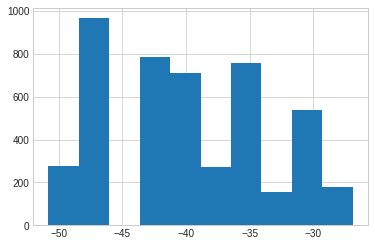

In [0]:
plt.hist(df1['cons.conf.idx'])

(array([3.3700e+02, 7.2860e+03, 9.0000e+00, 1.3890e+04, 8.2300e+02,
        2.6600e+02, 1.2618e+04, 1.9600e+02, 8.5600e+02, 2.6700e+02]),
 array([-50.8 , -48.41, -46.02, -43.63, -41.24, -38.85, -36.46, -34.07,
        -31.68, -29.29, -26.9 ]),
 <a list of 10 Patch objects>)

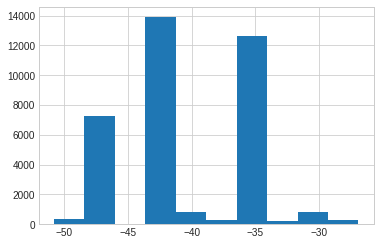

In [0]:
plt.hist(df0['cons.conf.idx'])

In [0]:
df['cons_conf_1'] = np.where( df['cons.conf.idx']<-47.5, 1, 0)
df['cons_conf_2'] = np.where( df['cons.conf.idx']>-35, 1, 0)
df['cons_conf_3']   = np.where( (df['cons.conf.idx']<-35) & (df['cons.conf.idx']>-47.5), 1, 0)
print(df.corr()['target'])

age                 0.030399
campaign           -0.066357
pdays              -0.324914
previous            0.230181
emp.var.rate       -0.298334
cons.price.idx     -0.136211
cons.conf.idx       0.054878
euribor3m          -0.307771
nr.employed        -0.354678
target              1.000000
age_young           0.062879
age_mid_age        -0.150745
age_elder           0.162728
campaign_C1         0.048504
campaign_C2         0.003559
campaign_C3        -0.006329
campaign_C4        -0.015535
campaign_C5        -0.023905
campaign_C6        -0.054616
pdays_999          -0.324877
cons_price_above   -0.081403
cons_price_below    0.213917
cons_price_mid     -0.014703
cons_conf_1         0.131698
cons_conf_2         0.258484
cons_conf_3        -0.293863
Name: target, dtype: float64


#euribor3m

(array([1.941e+03, 1.237e+03, 1.230e+02, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.490e+02, 3.400e+01, 1.155e+03]),
 array([0.634 , 1.0751, 1.5162, 1.9573, 2.3984, 2.8395, 3.2806, 3.7217,
        4.1628, 4.6039, 5.045 ]),
 <a list of 10 Patch objects>)

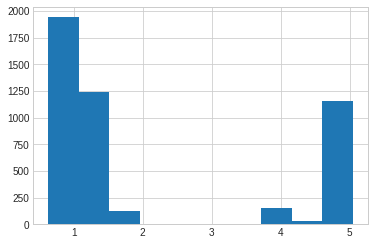

In [0]:
plt.hist(df1['euribor3m'])

In [0]:
df['euribor3m'].unique()

Since this variable has a lot of values lets say with it as numeric instead of trying to split into groups.

#nr.employed

Let's analyze the the nr.employed now...

(array([ 301.,  772.,  542.,    0.,  594., 1092.,    0.,    0.,  473.,
         866.]),
 array([4963.6 , 4990.05, 5016.5 , 5042.95, 5069.4 , 5095.85, 5122.3 ,
        5148.75, 5175.2 , 5201.65, 5228.1 ]),
 <a list of 10 Patch objects>)

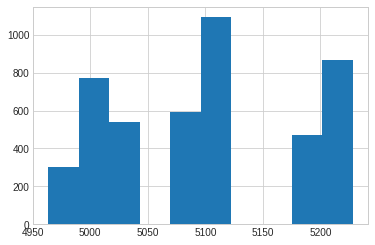

In [0]:
plt.hist(df1['nr.employed'])

(array([  334.,   651.,   701.,     0.,  1069.,  7442.,     0.,     0.,
        10983., 15368.]),
 array([4963.6 , 4990.05, 5016.5 , 5042.95, 5069.4 , 5095.85, 5122.3 ,
        5148.75, 5175.2 , 5201.65, 5228.1 ]),
 <a list of 10 Patch objects>)

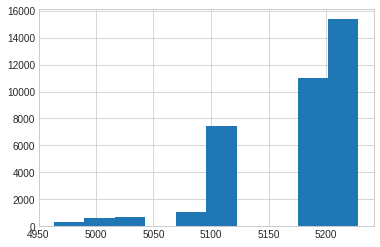

In [0]:
plt.hist(df0['nr.employed'])

From the histograms seens reasonable to split in 3 groups:

In [0]:
df['nr_1'] = np.where( df['nr.employed']<5050, 1, 0)
df['nr_2'] = np.where( df['nr.employed']>5150, 1, 0)
df['nr_3'] = np.where( (df['nr.employed']<5150) & (df['nr.employed']>5050), 1, 0)
print(df.corr()['target'])

age                 0.030399
campaign           -0.066357
pdays              -0.324914
previous            0.230181
emp.var.rate       -0.298334
cons.price.idx     -0.136211
cons.conf.idx       0.054878
euribor3m          -0.307771
nr.employed        -0.354678
target              1.000000
age_young           0.062879
age_mid_age        -0.150745
age_elder           0.162728
campaign_C1         0.048504
campaign_C2         0.003559
campaign_C3        -0.006329
campaign_C4        -0.015535
campaign_C5        -0.023905
campaign_C6        -0.054616
pdays_999          -0.324877
cons_price_above   -0.081403
cons_price_below    0.213917
cons_price_mid     -0.014703
cons_conf_1         0.131698
cons_conf_2         0.258484
cons_conf_3        -0.293863
nr_1                0.351583
nr_2               -0.291273
nr_3                0.095591
Name: target, dtype: float64


Correlation did not improve, lets stay with nr.employed

#Categorical variables

We will apply the same strategy for all categorical variables. Since we do not have a lot of categories.

In [0]:
def categorical_encoding(df):
  
  total_categorical = 0
  each_categorical  = 0
  cat_columns = list(df.select_dtypes(include=['object']).columns)
  print('Cat Columns')

  for cat_column in cat_columns:
    #Important line because is adding column name prefix to generate the dummies
    dummy = pd.get_dummies(df[cat_column],prefix=cat_column,columns=cat_columns)
    df = pd.concat([df,dummy],axis=1)
    df.drop([cat_column], axis=1,inplace=True)
  
  useless_columns = remove_useless(df)
  
  for col in useless_columns:
    df.drop([col], axis=1,inplace=True)
  
  return df

#Correlation

In [0]:
corr = df.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False                
selected_columns = df.columns[columns]
data = df[selected_columns]

set1 = set(corr.columns)
set2 = set(selected_columns)
print(list(set1-set2))

[]


#PIPELINE

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
pd.set_option('display.max_columns',500)

url = 'https://raw.githubusercontent.com/DTribek/datasets/master/bank-additional-full-train.csv'
df   = pd.read_csv(url,sep=';')

url2 = 'https://raw.githubusercontent.com/DTribek/datasets/master/bank-additional-val.csv'
df_validation  = pd.read_csv(url2,sep=';')

print('Imports OK!')

def categorical_encoding(df):
  
  total_categorical = 0
  each_categorical  = 0
  cat_columns = list(df.select_dtypes(include=['object']).columns)
  print('Cat Columns')

  for cat_column in cat_columns:
    #Important line because is adding column name prefix to generate the dummies
    dummy = pd.get_dummies(df[cat_column],prefix=cat_column,columns=cat_columns)
    df = pd.concat([df,dummy],axis=1)
    df.drop([cat_column], axis=1,inplace=True)
  
  useless_columns = remove_useless(df)
  
  for col in useless_columns:
    df.drop([col], axis=1,inplace=True)

  return df

def remove_useless(df):
  
  print("Analysing categorical correlation")
  
  #Get all columns generated by dummies method plus target
  new_columns = list(df.select_dtypes(include=['uint8']).columns)
  new_columns.append('target')
  corr_df = df.loc[ : , new_columns ]
  corr_df = corr_df.corr()['target']
  useless_columns = []
  
  #if correlation is small, column will be added into list.
  #the idea is to remove all useless columns
  for i in range(len(corr_df.index)):
    
    if(abs(corr_df[i])<0.00):
      useless_columns.append(corr_df.index[i])
  
  print('Finished Categorial Correlation')
  
  return useless_columns

def numerical_data(dataframe):
    
    print('Numerical starting...')
    
    dataframe = group_age(dataframe)
    print('Age finished!')

    print('Campaign finished!')
    
    dataframe['pdays_999']   = np.where( dataframe['pdays']==999, 1, 0)
    dataframe.drop(columns='pdays',inplace=True)
    print('pdays Finished!')
    
    dataframe['cons_price_below'] = np.where( dataframe['cons.price.idx']<=92.75, 1, 0)
    dataframe.drop(columns='cons.price.idx',inplace=True)
    
    dataframe['cons_conf_1'] = np.where( dataframe['cons.conf.idx']<-47.5, 1, 0)
    dataframe['cons_conf_2'] = np.where( dataframe['cons.conf.idx']>-35, 1, 0)
    dataframe['cons_conf_3']   = np.where( (dataframe['cons.conf.idx']<-35) & (dataframe['cons.conf.idx']>-47.5), 1, 0)
    dataframe.drop(columns='cons.conf.idx',inplace=True)
    
    
    #dataframe = group_previous(dataframe)
    print('Group Previous finished!')
    
    dataframe = scaler_df(dataframe)
    print('Scaler finished!')
    
    print('Numerical Ended')
    return dataframe

def group_age(df):
    
    df['age_young']   = np.where( df['age']<=25, 1, 0)
    df['age_mid_age'] = np.where((df['age']>25) & (df['age']< 60)  , 1, 0)
    df['age_elder']   = np.where( df['age']>60, 1, 0)
    df.drop(columns='age',inplace=True)
    
    return df
    
def scaler_df(dataframe):

  from sklearn import preprocessing
  # Create the Scaler object
  x = dataframe.values#returns a numpy array

  #Save the columns name
  num_columns = dataframe.columns

  #Normalize the numerical values
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  dataframe = pd.DataFrame(x_scaled)
  #Rename the columns with the previous saved names
  dataframe.columns = num_columns
  
  return dataframe

def pipeLine(df):
  print('Remaping target...')
  df['target'] = df['y'].map({'yes': 1, 'no': 0}) 
  df.drop(columns='y',inplace = True)
  print('Dropping duration column')
  df.drop(columns='duration',inplace = True)
  print('Categorical Data analysis beggining...')
  df = categorical_encoding(df)
  print('Categorical Data analysis ended')
  df = numerical_data(df)
  print('Numerical ended')
  df.drop(columns=['loan_unknown', 'nr.employed', 'euribor3m', 'cons_conf_2'],inplace=True)
  return df

print('Functions definitions OK!')


print('Data Load Properly!')


print('Pipeline Starting...')
df = pipeLine(df)
print('Pipeline Ended!')


Imports OK!
Functions definitions OK!
Data Load Properly!
Pipeline Starting...
Remaping target...
Dropping duration column
Categorical Data analysis beggining...
Cat Columns
Analysing categorical correlation
Finished Categorial Correlation
Categorical Data analysis ended
Numerical starting...
Age finished!
Campaign finished!
pdays Finished!
Group Previous finished!
Scaler finished!
Numerical Ended
Numerical ended
Pipeline Ended!


In [0]:
df.shape
df_1 = df[df['target']==1]
df_0 = df[df['target']==0]
print("Df shape:{} Df1 Shape:{} Df0 Shape:{}".format(df.shape,df_1.shape,df_0.shape))

Df shape:(41188, 63) Df1 Shape:(4640, 63) Df0 Shape:(36548, 63)


In [0]:
upsampled = resample(df_1,
                          replace=True, # sample with replacement
                          n_samples=round(len(df_1)*2), # double the minority
                          random_state=42) # reproducible results
df = shuffle(pd.concat([df_0, upsampled]))

In [0]:
print(upsampled.shape)
print(df.shape)

(9280, 63)
(45828, 63)


**Tentativa de divisão e learning por partes**

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# split into training and testing sets
from sklearn.model_selection import train_test_split


def splitDataFrameIntoSmaller(df,df1, chunkSize = 920): 
    listOfDf = list()
    numberChunks = 10
    for i in range(numberChunks):
        df_t = df[i*chunkSize:(i+1)*chunkSize*2]
        df_s = df1[i*chunkSize:(i+1)*chunkSize]
        listOfDf.append( shuffle (pd.concat([df_t,df_s])))
    return listOfDf


df1 = df[df['target']==1]
df0 = df[df['target']==0]

print(len(df1))
print(len(df0))
print(len(df))

lista_dataframe = splitDataFrameIntoSmaller(df0,df1) 

9280
36548
45828


#PIPELINE TRAIN TEST SPLIT

In [0]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
import math

def pipeline_train(df):
    #Get the columns from data
    features = list(df.columns)
    features.remove('target')
    
    X = df[features]
    y = df.target
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y,train_size=0.80)


    # prepare configuration for cross validation test harness
    seed = 42
    #Models list
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('XGB', XGBClassifier()))

    
    # evaluate each model in turn
    results = []
    names = []
        
    for name, model in models:
        model.fit(X_train,y_train)
        predicted = model.predict(X_test)
        precision, recall, fscore, support = score(y_test, predicted)
        
        tcc_fscore = math.sqrt(fscore[0]*fscore[1])
        results.append(tcc_fscore)
        names.append(name)
        print("{}: {} ".format(name, tcc_fscore))
    print('------------------------------------')    
    
    max_value = 0
    name = ''
    best_index = 0
    #Best result for each split...
    for index in range (0,len(results)):
        if results[index] > max_value:
            max_value = results[index]
            name = names[index]
            best_index = index
    print('Melhor modelo:{}'.format(models[best_index][0]))
    model_final = models[best_index][1].fit(X_train,y_train)
    print('----------------------------------')
    return (model_final)

In [0]:
mamodel = pipeline_train(df)

LR: 0.6543855599485717 
KNN: 0.7311365427597457 
CART: 0.8135463473017427 
RF: 0.849136661944769 
NB: 0.6715819617040253 
ABC: 0.6451542577797301 
GBC: 0.6945226513153849 
XGB: 0.6844136875251006 
------------------------------------
Melhor modelo:RF
----------------------------------


In [0]:
dic_ops = {}
index = 1
for item in lista_dataframe:
    dic_ops['SPLIT_'+str(index)] = pipeline_train(item)
    index = index + 1

LR: 0.7026356166043829 
KNN: 0.6328423872900442 
CART: 0.6603552345934464 
RF: 0.7028047068081161 
NB: 0.6791243120038364 
ABC: 0.7240139776611387 
GBC: 0.7217643432172329 
------------------------------------
Melhor modelo:ABC
----------------------------------
LR: 0.713806554893974 
KNN: 0.6146671585857543 
CART: 0.6549035948976841 
RF: 0.6969761402518568 
NB: 0.7198141948745511 
ABC: 0.7044598645249213 
GBC: 0.7113610954459086 
------------------------------------
Melhor modelo:NB
----------------------------------
LR: 0.6669187166730233 
KNN: 0.6413700470716588 
CART: 0.6202249955401976 
RF: 0.7025790667921885 
NB: 0.6636767613087913 
ABC: 0.6934594347549103 
GBC: 0.6914505738690917 
------------------------------------
Melhor modelo:RF
----------------------------------
LR: 0.6378046652465722 
KNN: 0.6204231384136456 
CART: 0.6475374705172892 
RF: 0.6513789981631594 
NB: 0.6907052446714546 
ABC: 0.6194022296416506 
GBC: 0.6265557347090939 
------------------------------------
Melh

In [0]:
url2 = 'https://raw.githubusercontent.com/DTribek/datasets/master/bank-additional-full-train.csv'
df   = pd.read_csv(url2,sep=';')

url = 'https://raw.githubusercontent.com/DTribek/datasets/master/bank-additional-val.csv'
df_validation =  pd.read_csv(url,sep=';')

df_validation = pipeLine(df_validation)
print(df_validation.shape)
features = list(df_validation.columns)
features.remove('target')


X_val = df_validation[features].values
y_val = df_validation['target'].values

In [0]:
preds = mamodel.predict(X_val)
precision, recall, fscore, support = score(y_val, preds)
tcc_fscore = math.sqrt(fscore[0]*fscore[1])
print(tcc_fscore)

0.8143655882647816


In [0]:
frames = pd.concat([df_validation,df])
print(frames.shape)
frames = frames.drop_duplicates(subset=None, keep='first', inplace=False)
print(frames.shape)

(45307, 81)
(45062, 81)


In [0]:
dic_ops

In [0]:
list_preds = []
list_probs = []



for split,model in dic_ops.items():
    res = model.predict(X_val)
    
    precision, recall, fscore, support = score(y_val, preds)
    tcc_fscore = math.sqrt(fscore[0]*fscore[1])
    print("{}:{}".format(model,tcc_fscore))
    #list_probs.append(model.predict_proba(X_train))
        

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None):0.8143655882647816
GaussianNB(priors=None, var_smoothing=1e-09):0.8143655882647816
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):0.8143655882647816
GaussianNB(priors=None, var_smoothing=1e-09):0.8143655882647816
GaussianNB(priors=None, var_smoothing=1e-09):0.8143655882647816
GaussianNB(priors=None, var_smoothing=1e-09):0.8143655882647816
GaussianNB(priors=None, var_smoothing=1e-09):0.8143655882647816
DecisionTreeClass

In [0]:
final_preds = np.zeros(len(list_preds[0]))
for item in list_preds:
    final_preds = final_preds + item

final_preds[final_preds<5]  = 0 
final_preds[final_preds>=5] = 1

In [0]:
precision, recall, fscore, support = score(y_val, final_preds)
tcc_fscore2 = math.sqrt(fscore[0]*fscore[1])
print(tcc_fscore)

#RandomizedSearch and GridSearch

We runned this locally, since it takes a lot of time in colab

**Grid**
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed: 74.2min finished
0.9106828528072838
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

**Randomized**
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
0.9042792109256449
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.15}
Best score 0.92 {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.2}





In [0]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import train_test_split

features = list(df.columns)
features.remove('target')
X = df[features]
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=df['target'],train_size=0.8)


random_grid = {'n_estimators': [5,10,50,100,200],
               'max_features': [10,20,30,40,50,60],
               'max_depth': [1,2,3,4,5,10,20,50],
              }

clf = RandomizedSearchCV(RandomForestClassifier(), random_grid, cv=10, n_jobs=-1,verbose=10)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished


0.956821777317113
{'n_estimators': 200, 'max_features': 60, 'max_depth': 20}
